**Task 01**

Your boss wants to know how electricity prices in NO2 and Germany have developed over the
sample period. Therefore, she has asked you to create a line plot that visualizes the hourly
electricity price in NO2 and Germany. The graph should:
- consist of two subplots: The first subplot shows the hourly electricity price in NO2 over time. 
The second subplot shows the hourly electricity price in Germany over time.
- add a vertical line to each subplot to indicate the official opening of Nordlink (December
9, 2020).
- be stored as a png file called “figure_task1.png”.

What is your conclusion? How has the electricity price in NO2 and Germany developed over
time? Have the prices increased or decreased after the opening of Nordlink? Extra: Do you have
any suggestions for why we sometimes observe negative electricity prices?

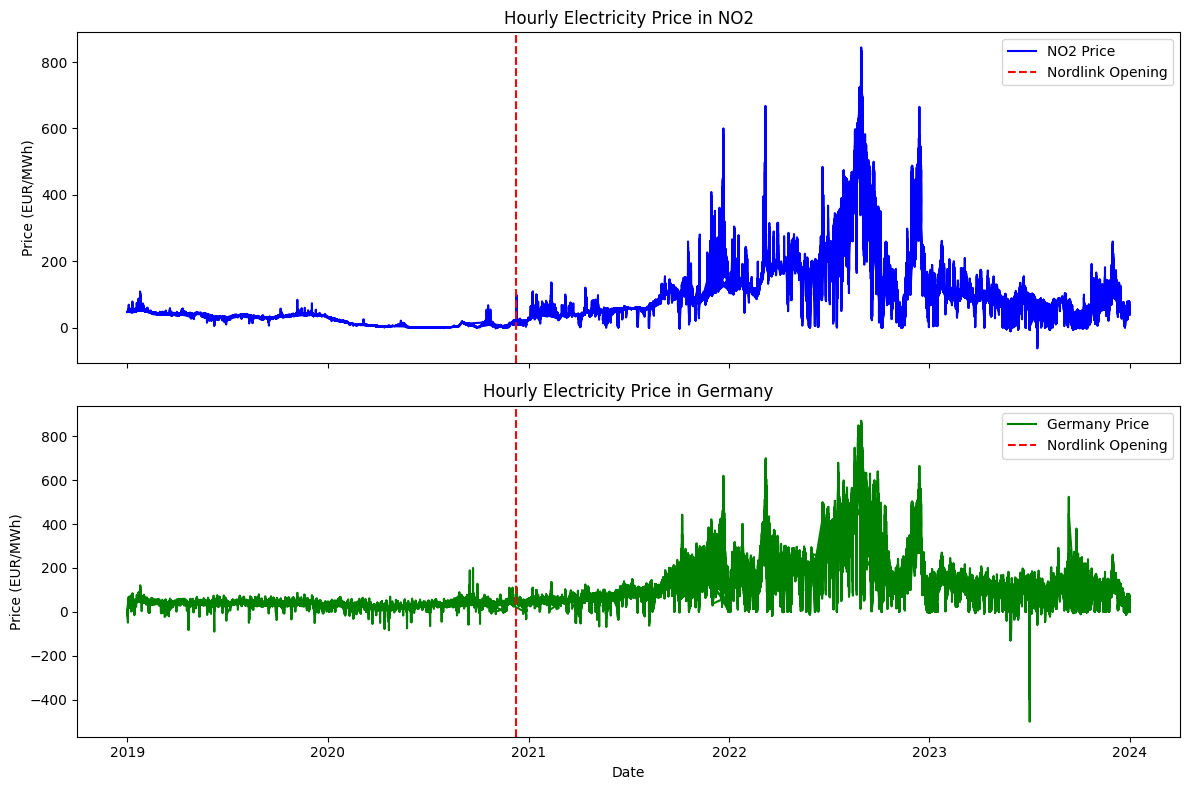

In [2]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

#Global Variables
data_path = 'data/DayAheadPrices_12.1.D'
file_matter = 'DayAheadPrices_12.1.D.csv'
nordlink_opening = datetime(2020, 12, 9)

"""
The total_filtered_data function is designed to extract, filter, and concatenate time-series data from 
multiple monthly files, allowing flexible handling of both pricing and physical flow data. This function 
is intended for use across all tasks, as it returns a dictionary containing separate data frames for 
pricing data (minimum required for Task 1) and physical data (necessary for subsequent tasks that involve 
additional operations based on conditionals).

Parameters:
    path (str): The base file path where the monthly data files are stored.
    matter (str): The data category to be extracted ("Prices" for pricing data or "Physical" for flow data).
    first_year (int): The starting year of the data range (default is 2019).
    last_year (int): The ending year of the data range (default is 2023).

Returns:
    dict: A dictionary containing two DataFrames:
        - 'price_data': A DataFrame with filtered price data for 'NO2' and 'DE_LU' if 'Prices' is in matter.
        - 'physical_data': A DataFrame with filtered physical data for 'NO2' and 'DE_LU' if 'Physical' is in matter.

Functionality:
    - Filters files by month and year within the specified range and verifies file existence.
    - For pricing data (if 'Prices' is in matter):
        - Filters to include only relevant regions ('NO2' and 'DE_LU') with hourly resolution ('PT60M').
        - Aggregates pricing data across the specified date range.
    - For physical data (if 'Physical' is in matter):
        - Filters records where 'InMapCode' and 'OutMapCode' include 'NO2' and 'DE_LU'.
        - Aggregates physical flow data across the specified date range.

This function is flexible and reusable for all tasks, as it conditionally returns either pricing data or 
physical flow data, depending on the 'matter' parameter. This dual-purpose design streamlines data retrieval 
for Task 1's pricing analysis and the physical data operations required in later tasks.
"""


#Function
def total_filtered_data(path, matter, first_year=2019, last_year=2023):
    df = []
    price_list = []
    physical_list = []
    for year in range(first_year, last_year +1):
        for month in range(1, 13):

            #Defining File Name
            file = f'{year}_{month:02}_{matter}'

            #Construct File Path
            file_path = os.path.join(path, file)

            #Checking File Existance
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path, delimiter='\t')

                #Converting DateTime into Datetime Format
                df['DateTime'] = pd.to_datetime(df['DateTime'])

                if 'Prices' in matter:

                    #Filter Data for Task 01
                    df = df[(df['MapCode'].isin(['NO2', 'DE_LU'])) & (df['ResolutionCode'] == 'PT60M')]
                    price_list.append(df[['MapCode', 'Price', 'DateTime']])

                elif 'Physical' in matter:
                    #Filter Data for Task 03
                    df = df[(df['InMapCode'].isin(['NO2', 'DE_LU'])) & (df['OutMapCode'].isin(['NO2', 'DE_LU']))]
                    physical_list.append(df[['DateTime', 'InMapCode', 'OutMapCode', 'FlowValue']])
            else:
                    raise ValueError(f'Not found: {file_path}')
    
    #Concatenate All Months, Each Year into one Data Frame
    full_data_price_list = pd.concat(price_list, ignore_index=True) if price_list else pd.DataFrame()
    full_data_physical_list = pd.concat(physical_list, ignore_index=True) if physical_list else pd.DataFrame()
    return {'price_data': full_data_price_list, 'physical_data': full_data_physical_list}

#Retrieving Data Frame for Task 01
data = total_filtered_data(data_path, file_matter)
price_data = data['price_data']

#Defining Diagram Data
data_no2 = price_data[price_data['MapCode'] == 'NO2']
data_delu = price_data[price_data['MapCode'] == 'DE_LU']

#Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

#Plot NO2 Data
axs[0].plot(data_no2['DateTime'], data_no2['Price'], color='blue', label='NO2 Price')
axs[0].axvline(nordlink_opening, color='red', linestyle='--', label='Nordlink Opening')
axs[0].set_title('Hourly Electricity Price in NO2')
axs[0].set_ylabel('Price (EUR/MWh)')
axs[0].legend()

#Plot DE_LU Data
axs[1].plot(data_delu['DateTime'], data_delu['Price'], color='green', label='Germany Price')
axs[1].axvline(nordlink_opening, color='red', linestyle='--', label='Nordlink Opening')
axs[1].set_title('Hourly Electricity Price in Germany')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price (EUR/MWh)')
axs[1].legend()

# Save the figure
plt.tight_layout()
plt.savefig('figure_task1.png')
plt.show()


**Conclusion 01**

Task 2

In [3]:
#Global Variables
data_path = 'data/DayAheadPrices_12.1.D'
file_matter = 'DayAheadPrices_12.1.D.csv'
data = total_filtered_data(data_path, file_matter)
price_data = data['price_data']

def statistics_to_excel(dataframe, start_year=2019, end_year=2023):
    #Defining Lists
    statistics_df = []
    statistics_table = []

    #Easing Filtering Process
    dataframe['Year'] = dataframe['DateTime'].dt.year

    #Creating & Appending Operations through Dictionaries to List
    for year in range(start_year, end_year +1):
        for mapcode in ['NO2', 'DE_LU']:
            subset_df = dataframe[(dataframe['Year'] == year) & (dataframe['MapCode'] == mapcode)]

            statistics = {
                'Year': year,
                'Region': mapcode,
                'Mean': round(subset_df['Price'].mean(), 2),
                'Median': round(subset_df['Price'].median(), 2),
                'StdDev': round(subset_df['Price'].std(), 2),
                'Min': round(subset_df['Price'].min(), 2),
                'Max': round(subset_df['Price'].max(), 2)
            }
            statistics_table.append(statistics)

    #Converting to Data Frame
    statistics_df = pd.DataFrame(statistics_table)

    #Writing to Excel
    statistics_df.to_excel('02Task_Statistics.xlsx', index=False)

    return statistics_df

statistics_to_excel(price_data)

,Year,Region,Mean,Median,StdDev,Min,Max
0,2019,NO2,39.26,38.81,8.23,5.86,109.45
1,2019,DE_LU,37.67,38.06,15.52,-90.01,121.46
2,2020,NO2,9.29,6.95,8.26,-1.73,99.92
3,2020,DE_LU,30.47,30.99,17.50,-83.94,200.04
4,2021,NO2,75.11,59.34,47.22,-1.97,600.16
5,2021,DE_LU,96.85,75.48,73.68,-69.00,620.00
6,2022,NO2,211.28,181.13,125.85,0.04,844.00
7,2022,DE_LU,235.44,208.34,142.82,-19.04,871.00
8,2023,NO2,79.44,80.46,36.28,-61.84,261.85
9,2023,DE_LU,95.18,98.02,47.58,-500.00,524.27


**Conclustion 02**

Task 3

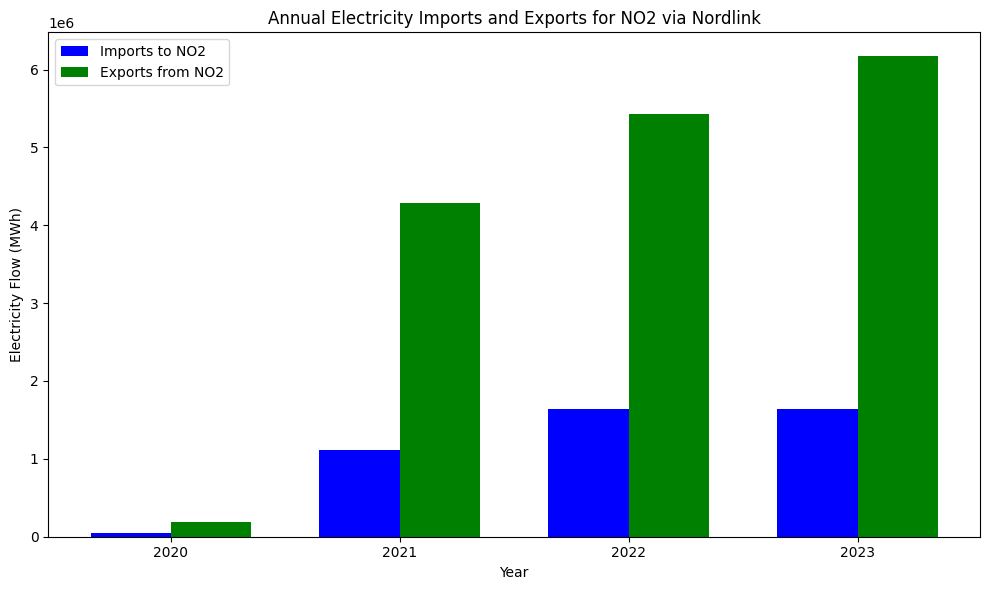

In [4]:
#Global Variables
data_path = 'data/PhysicalFlows_12.1.G'
file_matter = 'PhysicalFlows_12.1.G.csv'
nordlink_opening = datetime(2020, 12, 9)

#Total Data for Physical Flows
data = total_filtered_data(data_path, file_matter)
physical_data = data['physical_data']
period = 'year'
purpose = 'overview'

"""
The physical_flow function processes and analyzes physical energy flow data between two regions,
identifying and aggregating import/export flows for a specified time period.

Parameters:
- dataframe (pd.DataFrame): Input data containing 'DateTime', 'OutMapCode', 'InMapCode', and 'FlowValue'.
- period (str): Specifies the time aggregation level ('year' or 'week').
- purpose (str): Defines the type of calculation ('overview' for annual import/export totals, 'net' for weekly net exports).
- first_year (int): The start year for filtering the data.
- last_year (int): The end year for filtering the data.

Functionality:
1. Filters data within the specified year range.
2. Marks flows as 'export' or 'import' based on region codes and filters out irrelevant data.
3. Adjusts the FlowValue to be positive for exports and negative for imports, aiding in net calculations.
4. Handles different operations based on purpose and period:
   - 'overview' and 'year': Returns a summary DataFrame of total annual imports and exports.
   - 'net' and 'week': Returns a DataFrame with weekly net export values.

This function can be reused for Task 4, as it provides a customizable and structured way to analyze
annual or weekly physical flow data, which may be required for reporting or further analysis in that task.
"""


def physical_flow(dataframe, period='year', purpose='overview', first_year=2019, last_year=2023):
    # Filter Years
    dataframe = dataframe[(dataframe['DateTime'].dt.year >= first_year) & 
                          (dataframe['DateTime'].dt.year <= last_year)]
    
    #Mark Exports or Imports
    dataframe['FlowType'] = dataframe.apply(
        lambda row: 'export' if row['OutMapCode'] == 'NO2' and row['InMapCode'] == 'DE_LU' else
                    'import' if row['OutMapCode'] == 'DE_LU' and row['InMapCode'] == 'NO2' else None, axis=1)
    
    #Drop Irrelevant Data
    dataframe = dataframe[dataframe['FlowType'].notna()]

    #Exports are Positive, Imports are Negative, Aids Net Calculation
    dataframe['FlowValue'] = dataframe.apply(lambda x: x['FlowValue'] if x['FlowType'] == 'export' else -x['FlowValue'], axis=1)

    #Handle Different Operations
    if purpose == 'overview' and period == 'year':
        annual_imports = dataframe[dataframe['FlowType'] == 'import'].groupby(dataframe['DateTime'].dt.year)['FlowValue'].sum().abs()
        annual_exports = dataframe[dataframe['FlowType'] == 'export'].groupby(dataframe['DateTime'].dt.year)['FlowValue'].sum()
        overview_data = pd.DataFrame({'imports': annual_imports, 'exports': annual_exports})
        return overview_data

    elif purpose == 'net' and period == 'week':
        weekly_net = dataframe.resample('W', on='DateTime')['FlowValue'].sum()
        weekly_net_df = weekly_net.reset_index()
        weekly_net_df.columns = ['Date', 'Net Export']
        return weekly_net_df

    else:
        raise ValueError("Invalid combination of period and purpose. Use 'year' for period with 'overview' or 'week' for period with 'net'.")

annual_flow_no2 = physical_flow(physical_data, period, purpose)

#Prepare Variables for Visualization
years = annual_flow_no2.index.tolist()
import_values = annual_flow_no2['imports'].tolist()
export_values = annual_flow_no2['exports'].tolist()

#Plotting
fig, ax = plt.subplots(figsize=(10, 6))

#Creating Bar Width and Position
bar_width = 0.35
r1 = range(len(years))
r2 = [x + bar_width for x in r1]

#Bar Plot Imports and Exports
ax.bar(r1, import_values, color='blue', width=bar_width, label='Imports to NO2')
ax.bar(r2, export_values, color='green', width=bar_width, label='Exports from NO2')

#Adding Labels and Titles
ax.set_xlabel('Year')
ax.set_ylabel('Electricity Flow (MWh)')
ax.set_title('Annual Electricity Imports and Exports for NO2 via Nordlink')
ax.set_xticks([r + bar_width / 2 for r in range(len(years))])
ax.set_xticklabels(years)
ax.legend()

#Saving Figure
plt.tight_layout()
plt.savefig('figure_task3.png')
plt.show()

**Conclusion 03**

Task 4

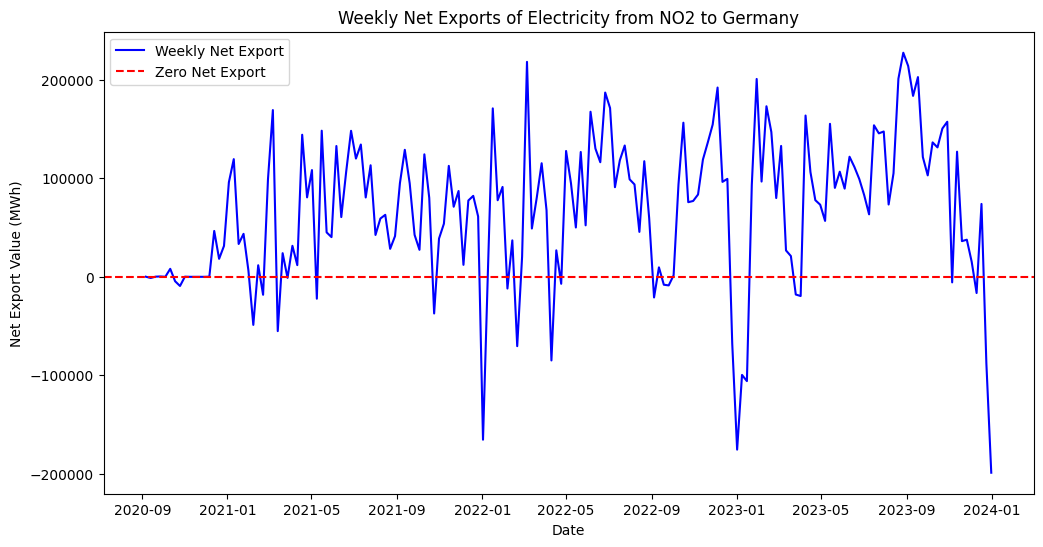

In [5]:
#Global Variables
data_path = 'data/PhysicalFlows_12.1.G'
file_matter = 'PhysicalFlows_12.1.G.csv'
nordlink_opening = datetime(2020, 12, 9)

#NO2 Net Export, Weekly for Physical Flows
data = total_filtered_data(data_path, file_matter)
physical_data = data['physical_data']
period = 'week'
purpose = 'net'


weekly_net_exports_df = physical_flow(physical_data, period, purpose)

#Plotting
plt.figure(figsize=(12, 6))

#Line Plot Weekly Net Export
plt.plot(weekly_net_exports_df['Date'], weekly_net_exports_df['Net Export'], label='Weekly Net Export', color='blue')

plt.axhline(y=0, color='red', linestyle='--', label='Zero Net Export')

#Titles and Labels
plt.title('Weekly Net Exports of Electricity from NO2 to Germany')
plt.xlabel('Date')
plt.ylabel('Net Export Value (MWh)')
plt.legend()

#Saving PNG
plt.savefig("figure_task4.png", format='png')

#Displaying
plt.show()

**Conclusion 04**

Task 5

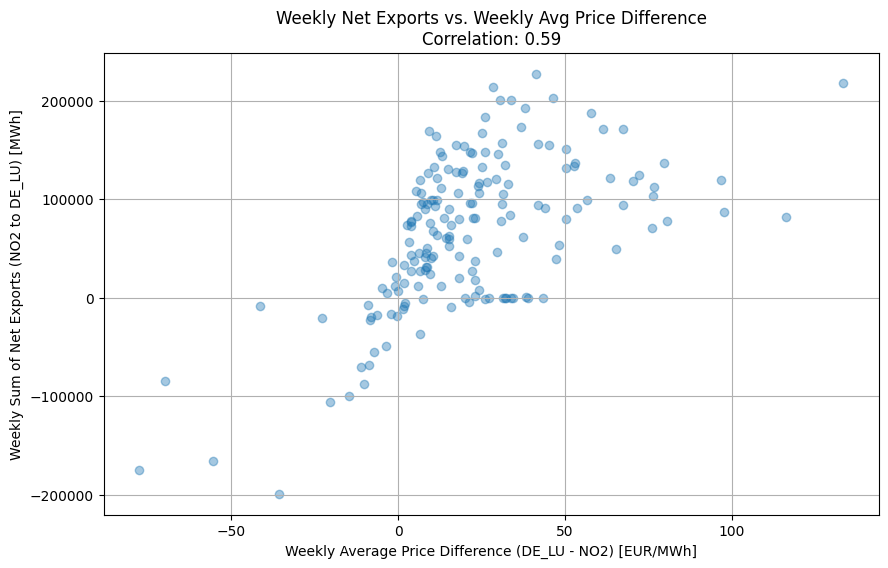

In [12]:
#Global Variables
no2_data_path = 'data/PhysicalFlows_12.1.G'
no2_file_matter = 'PhysicalFlows_12.1.G.csv'
delu_data_path = 'data/DayAheadPrices_12.1.D'
delu_file_matter = 'DayAheadPrices_12.1.D.csv'
nordlink_opening = datetime(2020, 12, 9)

#NO2 Weekly Net Export, for Physical Flows
data = total_filtered_data(no2_data_path, no2_file_matter)
physical_data = data['physical_data']
period = 'week'
purpose = 'net'

#DE_LU Weekly Average Price, for Price
data = total_filtered_data(delu_data_path, delu_file_matter)
pricing_data = data['price_data']

"""
The pricing_export_correlation function provides insight into relationship between export patterns and price differentials for two defined regions.

Parameters:
    pricing_data (pd.DataFrame): DataFrame containing electricity prices, with 'DateTime' and 'MapCode' columns.
    physical_data (pd.DataFrame): DataFrame containing physical flow data with 'DateTime', 'InMapCode', 'OutMapCode', and 'FlowValue' columns.
    mapcode1 (str): The 'MapCode' representing the first region (e.g., 'DE_LU' for Germany).
    mapcode2 (str): The 'MapCode' representing the second region (e.g., 'NO2' for Norway).

Functionality:
1. Calculates Weekly Average Price Difference:
2. Calculates Weekly Net Export leveraging physical_flow function from Task 3
3. Merges Weekly Net Export and Weekly Average Difference
4. Computes the Correlation for these two metrics.

Returns:
    pd.DataFrame: A merged DataFrame containing the weekly average price difference and weekly net exports.
    float: The correlation coefficient between weekly net exports and weekly average price difference.

Reusability:
    - physical_flow function is reused making pricing_export_correlation easier to adapt
"""


def pricing_export_correlation(pricing_data, physical_data, mapcode1, mapcode2):
    #Pricing for Each Region
    pivot_pricing_data = pricing_data.pivot(index='DateTime', columns='MapCode', values='Price')
    
    #Calculating Hourly Price Differences
    pivot_pricing_data['Hourly Price Difference'] = pivot_pricing_data[mapcode1] - pivot_pricing_data[mapcode2]
    weekly_avg_price_difference = pivot_pricing_data['Hourly Price Difference'].resample('W').mean().reset_index()
    weekly_avg_price_difference.columns = ['Date', 'Weekly Avg Price Difference']
    
    #Calculating NO2 Net Export
    weekly_net_export_df = physical_flow(physical_data, period, purpose)
    
    #Merge Net Export & Pricing Data
    pricing_export_df = pd.merge(weekly_net_export_df, weekly_avg_price_difference, on='Date').dropna()

    #Calculate Correlation
    correlation = pricing_export_df['Net Export'].corr(pricing_export_df['Weekly Avg Price Difference'])

    return pricing_export_df, correlation

pricing_export_df, correlation = pricing_export_correlation(pricing_data, physical_data, 'DE_LU', 'NO2')

#Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pricing_export_df['Weekly Avg Price Difference'], pricing_export_df['Net Export'], alpha=0.4)
plt.title(f"Weekly Net Exports vs. Weekly Avg Price Difference\nCorrelation: {correlation:.2f}")
plt.xlabel("Weekly Average Price Difference (DE_LU - NO2) [EUR/MWh]")
plt.ylabel("Weekly Sum of Net Exports (NO2 to DE_LU) [MWh]")
plt.grid(True)
plt.savefig("figure_task5.png")
plt.show()

**Conclusion 05**